In the first 2 learning units, we saw the so-called **Bag of Words** vectorization of text. Text is transformed in vectors, constituted by counts or frequencies of words. This representation has the advantage of being simple and lasted for a very long time.

A possible improvement to this idea is, instead of considering single words, to consider sequences of them. So, you can create features for 2 consecutives words, or even 3. You can even consider sequences of letters, or phonems. This approach is called **n-grams** reprensentation, and it could be very effective as well. Since we are not going to cover it in this material, you can find a very interesting explanation [here](https://www.youtube.com/watch?v=s3kKlUBa3b0&index=12&list=PL6397E4B26D00A269).

An important breakthrough in text representation has been made during recent past by using deep learning. The family of algorithms called **word embedding** - the most famous being `word2vec` - is based on training neural network to automatically learn the more informative representation for text data. The networks are trained to produce vectors that embed semantic information extracted from text. For example,  words with similar meaning produces vectors that are close to one another in the vector space.

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

# GenSim
import gensim

Train those kind of models is **very** computationally expensive. The good news is that, once trained by those guys with the big computers, we can happily use the trained models to project text to the feature space. 

Thankfully, we can go [here](http://nlpserver2.inf.ufrgs.br/alexandres/vectors/lexvec.enwiki%2bnewscrawl.300d.W.pos.vectors.gz) and download a LexVec word embedding model (similar to word2vec and [GloVe](https://nlp.stanford.edu/projects/glove/)) pre-trained on Wikipedia.

Small note: the models have to be trained on text of the same language. So, one of the problems with such an approach is that most of tools are only available for English language.

Another small note: be careful, this will load a **pretty big** object in memory. 

In [2]:
# Load Google's pre-trained Word2Vec model.
model = gensim.models.KeyedVectors.load_word2vec_format('./lexvec.enwiki+newscrawl.300d.W.pos.vectors')

As we said earlier, we have some cool properties in this vector space. We can treat words as numbers. What do you expect from `woman + king - man`?

In [3]:
model.wv.most_similar(positive=['woman', 'king'], negative=['man'])

[('queen', 0.6212161779403687),
 ('monarch', 0.5939741730690002),
 ('prince', 0.565595269203186),
 ('throne', 0.5191949009895325),
 ('princess', 0.5010462403297424),
 ('emperor', 0.4941234588623047),
 ('consort', 0.4744755029678345),
 ('empress', 0.47122541069984436),
 ('regent', 0.4650477468967438),
 ('betrothed', 0.45985016226768494)]

Ok, that was nice. Let's see how things work with real data.

In [4]:
df = pd.read_csv('../hackathon-5-learning/02-text-in-practice/data/uci-news-aggregator.csv')
df.dtypes

ID            int64
TITLE        object
URL          object
PUBLISHER    object
CATEGORY     object
STORY        object
HOSTNAME     object
TIMESTAMP     int64
dtype: object

In [5]:
df = df[['TITLE', 'CATEGORY']]
df.columns = ['title', 'category']
_, data = train_test_split(df, test_size=0.3, random_state=42)  # subsampling to help performance
train_df, validation_df = train_test_split(data, test_size=0.2, random_state=42)
train_df.head()

,title,category
80923,"UPDATE 2-China factories struggle, adds to exp...",b
398657,Real estate website operator Zillow buying Tru...,b
167770,"George Clooney's dad Nick ""thrilled"" about Ama...",e
79985,#CZLNY: 10 New Media Trends Shaping the Lives ...,b
170486,Toyota: Move to Texas 'most significant change...,b


In [6]:
# Extract document tokens
documents = train_df
tokens = [[word for word in document.split()] for document in documents['title']]

In [7]:
# Convert each token (word) into vector representation
vectors = [np.array([model.wv[token] if token in model.wv else model.wv['the'] for token in sentence]) for sentence in tokens]

In [20]:
vectors[0].shape

(9, 300)

For each document, we have now an array of vectors. One vector for each word. Argh, that's a lot of numbers! We can "summarize" each document. 

There are far smarter ways to do that, but to keep things simple, we can take the mean of all the words. We end up with a vector for each document:

In [8]:
# Average word vectors to get document representation
vectorized = np.array([document.mean(axis=0) for document in vectors])
vectorized.shape

(101380, 300)

Each document is now a 300-dimensional vector. 300 dimensions are not so many, but it's still a challenge to visualize them. 

We should definitely try out a couple of dimensionality reduction algorithms to reduce the space to a nice 2-dimensional cartesian space.

In [9]:
labels = documents['category']

color_map = {'b':'r', 't':'g', 'e':'b', 'm':'c'}
colors = [color_map[label] for label in labels]
size = [10 for i in range(len(labels))]

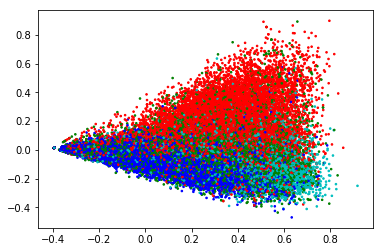

In [10]:
reduced_data = PCA(n_components=2).fit_transform(vectorized)

plt.scatter(reduced_data[:,0], reduced_data[:,1], marker='.', c=colors, s=size)

In [ ]:
reduced_data = TSNE(n_components=2).fit_transform(vectorized)

plt.scatter(reduced_data[:,0], reduced_data[:,1], marker='.', c=colors, s=size)

In [24]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

clf = LinearSVC(C=1)

clf.fit(vectorized, documents['category'])

LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [25]:
def vectorize(documents):
    tokens = [[word for word in document.split()] for document in documents['title']]
    vectors = [np.array([model.wv[token] if token in model.wv else model.wv['the'] for token in sentence]) for sentence in tokens]
    return np.array([document.mean(axis=0) for document in vectors])
    
vectorized_test = vectorize(validation_df)
predicted = clf.predict(vectorized_test)
np.mean(predicted == validation_df['category'])

0.60983981693363842